In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

# 修正したモデルから卒論時に集計したデータを作成する

1. 表

| ベンチマーク名 | 平均誤差率(%) | コスト比(%) |
|---------|----------|---------|


2. 表

| ベンチマーク名 | 採用割合(最大MAPE(%), 最小MAPE(%)) |
|---------|----------------------------|
|         | モデル(1), モデル(2), ...        |


<Figure size 288x216 with 0 Axes>

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均誤差率(%)')

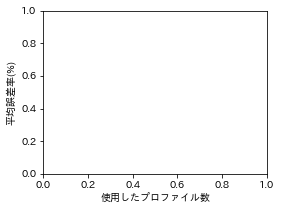

In [2]:
plt.figure(figsize=(4,3))
plt.xlabel("使用したプロファイル数")
plt.ylabel("平均誤差率(%)")

In [3]:

benchmark = "mg"
fix = "Class"
if benchmark=="bt" or benchmark=="sp":
    processes = processes_onlyBTSP
else:
    processes = processes_excludeBTSP
benchmarkClasses=["A", "B", "C", "D"]
fixedBenchmarkClass="B"
fixedProcess=64

DF = returnRawDFperBenchmark(Benchmark=benchmark, fix=fix, benchmarkClass=benchmarkClasses, FixedProcess=fixedProcess, Processes=processes, FixedBenchmarkClass=fixedBenchmarkClass)
noNaNDF = DF.dropna(how='any')

# noNaNDF
functionNames = noNaNDF.index.tolist()
functionNames
processes = noNaNDF.columns.tolist()

calculatedDF = pd.DataFrame(columns=return_numOfColumns())
calculatedDF = calculatedDF.astype(return_numOfColumns(dataType=True))

functionName = functionNames[2]
for i in reversed(range(len(processes))):
    print(processes[:i+1])
    dataSeries = pd.Series(index=return_numOfColumns())
    dataSeries["benchmarkName"] = benchmark
    dataSeries["functionName"] = functionName
    dataSeries["usedData"] = processes[:i+1]
    dataSeries["numOfData"] = len(processes[:i+1])
    dataSeries["ProcessOrClass"] = fix
    dataSeries["fixed"] = ConvertBencharkClass_inNPB(fixedBenchmarkClass)
    dataSeries["targetNumOfProcess"] = 256
    dataSeries["targetNumOfProblemSize"] = ConvertBencharkClass_inNPB(fixedBenchmarkClass)
    dataSeries["targetNumOfFunctionCall"] = -1
    
    # MAPE の算出には mape_score()を用いる
    # mape_score()の返り値の単位は％
    
    
    
#     dataSeries["objectLinModel"] = 
#     dataSeries["MAPEOfLinModel"] =
#     dataSeries["objectIpModel"] =
#     dataSeries["MAPEOfIpModel"] =
#     dataSeries["objectLogModel"] =
#     dataSeries["MAPEOfLogModel"] =
#     dataSeries["objectBranchModel"] =
#     dataSeries["MAPEOfBranchModel"] =
#     dataSeries["objectBestModel"] =
#     dataSeries["MAPEOfBestModel"] =
    calculatedDF = calculatedDF.append(dataSeries, ignore_index=True)
calculatedDF

['.TAU_application',
 'ALLOC_SPACE',
 'BUBBLE',
 'COMM3',
 'COMM3_EX',
 'INTERP',
 'MG3P',
 'MG_MPI',
 'MPI_Allreduce()',
 'MPI_Barrier()',
 'MPI_Bcast()',
 'MPI_Comm_rank()',
 'MPI_Comm_size()',
 'MPI_Finalize()',
 'MPI_Init()',
 'MPI_Reduce()',
 'NORM2U3',
 'POWER',
 'PSINV',
 'RESID',
 'RPRJ3',
 'SETUP',
 'ZERO3',
 'ZRAN3']

[1, 2, 4, 8, 16, 32, 64, 128, 256]
[1, 2, 4, 8, 16, 32, 64, 128]
[1, 2, 4, 8, 16, 32, 64]
[1, 2, 4, 8, 16, 32]
[1, 2, 4, 8, 16]
[1, 2, 4, 8]
[1, 2, 4]
[1, 2]
[1]


<ipython-input-3-1f00284e5285>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dataSeries = pd.Series(index=return_numOfColumns())


,benchmarkName,functionName,usedData,numOfData,ProcessOrClass,fixed,targetNumOfProcess,targetNumOfProblemSize,targetNumOfFunctionCall,objectLinModel,MAPEOfLinModel,objectIpModel,MAPEOfIpModel,objectLogModel,MAPEOfLogModel,objectBranchModel,MAPEOfBranchModel,objectBestModel,relativeErrorOfBestModel
0,mg,BUBBLE,"[1, 2, 4, 8, 16, 32, 64, 128, 256]",9,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mg,BUBBLE,"[1, 2, 4, 8, 16, 32, 64, 128]",8,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mg,BUBBLE,"[1, 2, 4, 8, 16, 32, 64]",7,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mg,BUBBLE,"[1, 2, 4, 8, 16, 32]",6,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mg,BUBBLE,"[1, 2, 4, 8, 16]",5,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mg,BUBBLE,"[1, 2, 4, 8]",4,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,mg,BUBBLE,"[1, 2, 4]",3,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,mg,BUBBLE,"[1, 2]",2,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,mg,BUBBLE,[1],1,Class,4.0,256,4.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
DF = returnRawDFperBenchmark(Benchmark="mg", fix="Process",benchmarkClass=["A", "B", "C", "D"], Processes=[1,2,4,8,16,32,64,128,256], FixedBenchmarkClass="B", FixedProcess=64)
DF.dropna(how='any')
DF

,A,B,C,D
Name,,,,
.TAU_application,1.000,1.000,1.000,1.000
ALLOC_SPACE,1.000,1.000,1.000,1.000
BUBBLE,444.219,444.219,529.125,612.562
COMM3,119.000,487.000,550.000,1483.000
COMM3_EX,35.000,147.000,168.000,459.000
GIVE3,661.500,2701.500,3079.500,8362.500
GIVE3_EX,15.000,63.000,63.000,153.000
INTERP,35.000,147.000,168.000,459.000
MG3P,5.000,21.000,21.000,51.000


,A,B,C,D
Name,,,,
.TAU_application,1.000,1.000,1.000,1.000
ALLOC_SPACE,1.000,1.000,1.000,1.000
BUBBLE,444.219,444.219,529.125,612.562
COMM3,119.000,487.000,550.000,1483.000
COMM3_EX,35.000,147.000,168.000,459.000
GIVE3,661.500,2701.500,3079.500,8362.500
GIVE3_EX,15.000,63.000,63.000,153.000
INTERP,35.000,147.000,168.000,459.000
MG3P,5.000,21.000,21.000,51.000
